<a href="https://colab.research.google.com/github/mikeboyle321/Macromolecular_Engineering_Nanoparticle_Transport/blob/main/Worked_Example_DLVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extended DLVO - colloid interactions with a substrate in electrolyte solutions.

This notebook walks through the analysis of a PS Nanoparticle Interacting with a silica substrate as a function of distance from the substrate using an extended DLVO model adapted from 

Handol Lee, Doris Segets, Sebastian Süß, Wolfgang Peukert, Sheng-Chieh Chen, David Y.H. Pui,
Liquid filtration of nanoparticles through track-etched membrane filters under unfavorable and different ionic strength conditions: Experiments and modeling,
Journal of Membrane Science,
Volume 524,
2017,
Pages 682-690,
ISSN 0376-7388,
https://doi.org/10.1016/j.memsci.2016.11.023.
(https://www.sciencedirect.com/science/article/pii/S0376738816312352)


In [1]:
# Import key python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, rc
from ipywidgets import interactive, IntSlider, RadioButtons, FloatText, IntText, FloatSlider
# set font size for plots globally
plt.rcParams.update({'font.size': 14})

## First we need to define some key constants

In [2]:
kb = 1.38064852E-23 # J/K, boltzmann constant
lambda_char = 100*1E-9 # m, 100 nm characteristic retardation wavelength ~ ionization wavelength
e_0 = 8.85418782E-12 # F/m
e_r = 78.4 # relative permittivity of water
e_coulomb = 1.602176634E-19 # C 
T = 237.15 + 21.04 # K
Na = 6.022E23 #/mol, Avogadro

## Plot the VdW interaction potential for varying separation particle sizes
* Van der Waals interaction constants from Israelachvili, J.N., Intermolecular and Surface Forces, Third Edition 2011


A_eff = 1.0980904698146341e-21 J


Text(0, 0.5, '$\\frac{\\phi_{VdW}}{k_{b}T}$')

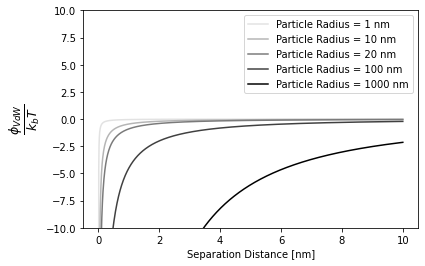

In [3]:
# Define a function for calcuating VdW forces
def calc_vdw(h_min, h_max, r_np_calc, A_vdw, lambda_ion):
  h_calc = np.linspace(h_min, h_max, 1000)*1E-9 # m
  r_calc = r_np_calc*1E-9 # converts nm to m
  phi_vdw_calc = (-A_vdw*r_calc*(1 + 14*h_calc/lambda_ion)**(-1))/(6*h_calc) # J
  return h_calc, phi_vdw_calc # returns m, J

# Use combination rule to estimate Hamaker Constant, A_eff
A_ps = np.mean([6.6E-20, 7.9E-20])  # J
A_h2o = np.mean([3.7E-20, 5.5E-20]) # J
A_sio2 = np.mean([5E-20, 6E-20]) # J
A_eff = (np.sqrt(A_ps) - np.sqrt(A_h2o))*(np.sqrt(A_sio2) - np.sqrt(A_h2o)) # J
print(f'A_eff = {A_eff} J')

# define constants
r_np = [1,10, 20, 100, 1000] #test  differnt parictle diameters, nm
sep_min = 0.001 # nm
sep_max = 10 # nm
kT = kb*T
for i, value in enumerate(r_np):
  h, phi_vdw = calc_vdw(h_min = sep_min, h_max = sep_max, r_np_calc = value, A_vdw=A_eff, lambda_ion = lambda_char)
  plt.plot(h*1E9, phi_vdw/kT, color =  plt.cm.Greys((1/len(r_np))*(i+1)), label = ('Particle Radius = ' + str(value) + ' nm'))
  plt.legend()
plt.ylim([-10,10])
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{VdW}}{k_{b}T}$', fontsize=18)

# Plot the Electric Double Layer ion concentration profile for varying salt concentration

Debye Length for [NaCl]=0.001 M is 8.946391595739755 nm
k*r_np is 5.58884545404986
Debye Length for [NaCl]=0.01 M is 2.8290974282325965 nm
k*r_np is 17.673481125475476
Debye Length for [NaCl]=0.1 M is 0.8946391595739754 nm
k*r_np is 55.88845454049861
Debye Length for [NaCl]=1 M is 0.28290974282325965 nm
k*r_np is 176.73481125475476


Text(0, 0.5, '$\\frac{\\phi_{EDL}}{k_{b}T}$')

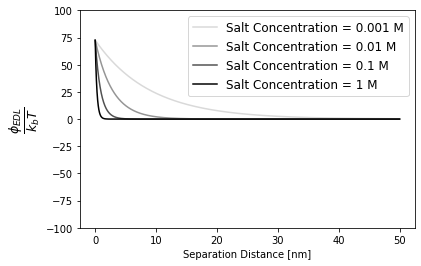

In [5]:
# Define a function for calcuating EDL forces
def calc_edl(h_min, h_max, r_np_calc, c_s_bulk_calc, z_ion_calc, psi_p_calc, psi_s_calc):
  psi_p_calc = psi_p_calc*1E-3 # converts mV to volts
  psi_s_calc = psi_s_calc*1E-3 # converts mV to volts
  h_calc = np.linspace(h_min, h_max, 1000)*1E-9 # m
  r_calc = r_np_calc*1E-9 # converts nm to m
  debye_param_calc = np.sqrt(2*(1000*c_s_bulk_calc*Na*e_coulomb**2*z_ion_calc**2)/(e_0*e_r*kb*T)) # m^-1
  # From Lee et. al
  # phi_edl_calc = (((64*np.pi*e_r*e_0)/debye_param_calc)*
  #                 (kb*T/(z_ion_calc*e_coulomb))**2*
  #                 np.tanh(z_ion_calc*e_coulomb*psi_s_calc/(4*kb*T))*
  #                 np.tanh(z_ion_calc*e_coulomb*psi_p_calc/(4*kb*T))*
  #                 ((debye_param_calc*r_calc - 1)*np.exp(-debye_param_calc*h_calc) + (debye_param_calc*r_calc + 1)*np.exp(-debye_param_calc*(h_calc+2*r_calc)))
  #                 )
  # from Adsorption and Desorption of Particles and Their Chromatographic Separation, Ruckenstein, Eli Prieve, Dennis C., AIChE Journal 1976
  # phi_edl_calc = (16*e_r*e_0*(kb*T/e_coulomb)**2*
  #                 r_calc*
  #                 np.tanh(z_ion_calc*e_coulomb*psi_s_calc/(4*kb*T))*
  #                 np.tanh(z_ion_calc*e_coulomb*psi_p_calc/(4*kb*T))*
  #                 np.exp(-debye_param_calc*h_calc)
  #                )
  # from Intermolecular and Surface Forces, Israelachvili
  phi_edl_calc = (r_calc*
                  ((64*np.pi*e_r*e_0))*
                  (kb*T/(z_ion_calc*e_coulomb))**2*
                  np.tanh(z_ion_calc*e_coulomb*psi_s_calc/(4*kb*T))*
                  np.tanh(z_ion_calc*e_coulomb*psi_p_calc/(4*kb*T))*
                  np.exp(-debye_param_calc*h_calc)
                  )
  print(f'Debye Length for [NaCl]={c_s_bulk_calc} M is {1/debye_param_calc*1E9} nm')
  print(f'k*r_np is {debye_param_calc*r_calc}')
  return h_calc, phi_edl_calc, 1/debye_param_calc*1E9 # returns m, J, nm - debye length

r_np = 50 # nm
psi_s = -25# mV
psi_p = -25 # mV
z = 1 # salt valency - 1 for monovalent salt like NaCl
c_salt = [0.001, 0.01, 0.1, 1] # concentration of salt in the bulk soltuion in mol/L
kT = kb*T
# define constants
sep_min = 0.001 # nm
sep_max = 50 # nm
kT = kb*T
for i, value in enumerate(c_salt):
  h, phi_edl, debye_length = calc_edl(h_min=sep_min, h_max=sep_max, r_np_calc=r_np, c_s_bulk_calc=value, z_ion_calc=z, psi_p_calc=psi_p, psi_s_calc=psi_s)
  plt.plot(h*1E9, phi_edl/kT, color =  plt.cm.Greys((1/len(c_salt))*(i+1)), label = ('Salt Concentration = ' + str(value) + ' M'))
plt.legend(fontsize=12)
plt.ylim([-100,100])
# plt.title('EDL for 100 nm PS particle in NaCl')
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{EDL}}{k_{b}T}$', fontsize=18)

## VdW Interaction potentials have a minimum at -inf as the separation between particle and substrate approaches 0. This is clearly non-physical. In real experiments (ignoring molecular complications of the continuum assumption breakdown), repulsive forces (solvation, steric hidrances from polymers layers) increase the interaction potential as a particle approceas the surface. To account for this, Lee .et *al* model short range repulsion (Pauli exclusion) from overlapping molecular orbitals via a Born Repulsion term with a potential shown below. It is based on a Hamaker type summation of the molecular expression of the Born repulsion following a distance dependency of h−12 for the sphere-plate geometry

Text(0, 0.5, '$\\frac{\\phi_{Born}}{k_{b}T}$')

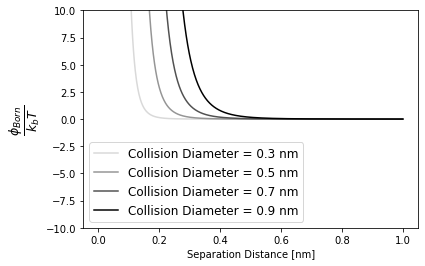

In [6]:
def calc_born_rep(h_min, h_max, A_vdw, sigma_collision, r_np_calc):
  h_calc = np.linspace(h_min, h_max, 1000)*1E-9 # m
  r_calc = r_np_calc*1E-9 # converts nm to m
  sigma_calc = sigma_collision*1E-9 # converts nm to m
  phi_born_calc = ((A_vdw*sigma_calc**6/7560)*
                   ((8*r_calc + h_calc)/((2*r_calc + h_calc)**7) + (6*r_calc - h_calc)/(h_calc**7))
                  )
  return h_calc, phi_born_calc

r_np = 10 # nm
sep_min = 0.001 # nm
sep_max = 1 # nm
sigma_collision_plot = [0.3, 0.5, 0.7, 0.9] # nm
kT = kb*T
for i, value in enumerate(sigma_collision_plot):
  h, phi_born = calc_born_rep(h_min=sep_min, h_max=sep_max, r_np_calc=r_np, A_vdw=A_eff, sigma_collision=value)
  plt.plot(h*1E9, phi_born/kT, color =  plt.cm.Greys((1/len(sigma_collision_plot))*(i+1)), label = ('Collision Diameter = ' + str(value) + ' nm'))
plt.legend(fontsize=12)
plt.ylim([-10,10])
# plt.title('EDL for 100 nm PS particle in NaCl')
plt.xlabel('Separation Distance [nm]')
plt.ylabel(r'$\frac{\phi_{Born}}{k_{b}T}$', fontsize=18)

# Interactively plot the competition between all of them, with option to change any parameters

In [9]:
def interactive_potential(h_min_int,
                          h_max_int,
                          r_np_calc_int,
                          A_vdw_int,
                          psi_p_calc_int,
                          psi_s_calc_int,
                          c_s_bulk_calc_int,
                          sigma_collision_int,
                          y_plot_min_int,
                          y_plot_max_int):
  
  h_vdw, phi_vdw = calc_vdw(h_min = h_min_int, 
                            h_max = h_max_int, 
                            r_np_calc = r_np_calc_int, 
                            A_vdw=A_vdw_int*1E-20, 
                            lambda_ion = lambda_char)

  h_edl, phi_edl, debye_l = calc_edl(h_min=h_min_int,
                            h_max=h_max_int,
                            r_np_calc=r_np_calc_int, 
                            c_s_bulk_calc=c_s_bulk_calc_int, 
                            z_ion_calc=1, 
                            psi_p_calc=psi_p_calc_int, 
                            psi_s_calc=psi_s_calc_int)
  
  h_born, phi_born = calc_born_rep(h_min=h_min_int,
                                   h_max=h_max_int, 
                                   A_vdw = A_vdw_int*1E-20, 
                                   sigma_collision=sigma_collision_int,
                                   r_np_calc=r_np_calc_int)
  
  phi_total = phi_born + phi_edl + phi_vdw
  # phi_total = phi_edl + phi_vdw

  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(h_vdw*1E9, phi_vdw/kT, 'k', linestyle='dotted', label='VdW')
  ax.plot(h_vdw*1E9, phi_edl/kT, 'k', linestyle='dashed', label='EDL')
  ax.plot(h_vdw*1E9, phi_born/kT, 'k', linestyle='dashdot', label='Born')
  ax.plot(h_vdw*1E9, phi_total/kT, 'k', linestyle='solid', label='Total')
  # ax.spines['bottom'].set_position('center')
  ax.set_xlabel('Separation Distance (nm)')
  ax.axhline(color='black', lw=1)
  ax.set_ylabel(r'$\frac{\phi}{k_{b}T}$', fontsize=18)
  ax.set_ylim([y_plot_min_int, y_plot_max_int])
  ax.set_xlim([0,h_max_int])
  plt.tight_layout()
  plt.savefig('interaction_potential.svg')
  ax.legend()

  data_frame_for_saving = pd.DataFrame()
  data_frame_for_saving['separation_distance (nm)'] = h_vdw*1E9
  data_frame_for_saving['phi_vdw (kt)'] = phi_vdw/kT
  data_frame_for_saving['phi_edl (kt)'] = phi_edl/kT
  data_frame_for_saving['phi_born (kt)'] = phi_born/kT
  data_frame_for_saving['phi_total (kt)'] = phi_total/kT
  data_frame_for_saving.to_csv('energy_separation.csv', index=None)

  params_df_for_saving_calcs = pd.DataFrame()
  params_df_for_saving_calcs['Temperature'] = [T]
  params_df_for_saving_calcs['r_np (nm)'] = [r_np_calc_int]
  params_df_for_saving_calcs['hamaker_constant (1E-20 J)'] = [A_vdw_int]
  params_df_for_saving_calcs['particle_zetap (mV)'] = [psi_p_calc_int]
  params_df_for_saving_calcs['substrate_zetap (mV)'] = [psi_s_calc_int]
  params_df_for_saving_calcs['salt_conc'] = [c_s_bulk_calc_int]
  params_df_for_saving_calcs['debye_l (nm)'] = [debye_l]
  params_df_for_saving_calcs['born_coll_diam (nm)'] = [sigma_collision_int]
  params_df_for_saving_calcs.to_csv('params.csv', index=None)

style = {'description_width': 'initial'}
interactive_potential_plot = interactive(interactive_potential, 
                                         h_min_int= FloatText(value=0.001,min=0.001, description='Separation Range Minimum [nm]', continuous_update=True, style=style),
                                         h_max_int= FloatText(value=15.0, description='Separation Range Maximum [nm]', continuous_update=True, style=style),
                                         r_np_calc_int = FloatSlider(value = r_np, min=1.0, max=100.0, step=1, description='Particle Radius (nm)', continuous_update=True, style=style),
                                         A_vdw_int = FloatSlider(value = 1.5, min=0.1, max=100, step=0.1, description='Hamaker Constant (10^-20 J)', continuous_update=True, style=style),
                                         psi_p_calc_int = FloatSlider(value = psi_p, min=-100, max=100, step=1, description='Particle Potential (mV)', continuous_update=True, style=style),
                                         psi_s_calc_int = FloatSlider(value = psi_s, min=-100, max=100, step=1, description='Substrate Potential (mV)', continuous_update=True, style=style),
                                         c_s_bulk_calc_int = FloatSlider(value = 0.01, min=0, max=1.0, step=0.01, description='[NaCl](M)', continuous_update=True, style=style, readout_format='.5f'),
                                         sigma_collision_int = FloatSlider(value = 0.5, min=0, max=2.0, step=0.1, description='Born Collision Diamete [nm]', continuous_update=True, style=style),
                                         y_plot_min_int = FloatText(value=-10, description='Plot kT Range Minimum', continuous_update=True, style=style),
                                         y_plot_max_int = FloatText(value=10, description='Plot kT Range Maximum', continuous_update=True, style=style)
                                         )

output = interactive_potential_plot.children[-1]
interactive_potential_plot

interactive(children=(FloatText(value=0.001, continuous_update=True, description='Separation Range Minimum [nm…

In [8]:
interactive_potential_plot.close

<bound method Widget.close of interactive(children=(FloatText(value=0.001, continuous_update=True, description='Separation Range Minimum [nm]', style=DescriptionStyle(description_width='initial')), FloatText(value=15.0, continuous_update=True, description='Separation Range Maximum [nm]', style=DescriptionStyle(description_width='initial')), FloatSlider(value=10.0, description='Particle Radius (nm)', min=1.0, step=1.0, style=SliderStyle(description_width='initial')), FloatSlider(value=1.5, description='Hamaker Constant (10^-20 J)', min=0.1, style=SliderStyle(description_width='initial')), FloatSlider(value=-25.0, description='Particle Potential (mV)', min=-100.0, step=1.0, style=SliderStyle(description_width='initial')), FloatSlider(value=-25.0, description='Substrate Potential (mV)', min=-100.0, step=1.0, style=SliderStyle(description_width='initial')), FloatSlider(value=0.01, description='[NaCl](M)', max=1.0, readout_format='.5f', step=0.01, style=SliderStyle(description_width='initia